In [1]:
import urllib.request
import zipfile
import os
import ssl
import certifi
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

# Create SSL context with certifi
ssl_context = ssl.create_default_context(cafile=certifi.where())

def download_and_unzip_spam_data(
        url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download "
              "and extraction."
        )
        return

    with urllib.request.urlopen(url, context=ssl_context) as response:    #1
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:    #2
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)               #3
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [2]:
import pandas as pd
df = pd.read_csv(
    data_file_path, sep="\t", header=None, names=["Label", "Text"]
)

In [3]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]     #1
    ham_subset = df[df["Label"] == "ham"].sample(
        num_spam, random_state=123
    )   
    for i, (idx, row) in enumerate(ham_subset.iterrows(), 1):
        print(f"{i}. [{idx}] {row['Text']}")
      
    print(ham_subset)                                #2
    balanced_df = pd.concat([
        ham_subset, df[df["Label"] == "spam"]
    ])                               #3
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

1. [4307] Awww dat is sweet! We can think of something to do he he! Have a nice time tonight ill probably txt u later cos im lonely :( xxx.
2. [4138] Just got to  &lt;#&gt;
3. [4831] The word "Checkmate" in chess comes from the Persian phrase "Shah Maat" which means; "the king is dead.." Goodmorning.. Have a good day..:)
4. [4461] This is wishing you a great day. Moji told me about your offer and as always i was speechless. You offer so easily to go to great lengths on my behalf and its stunning. My exam is next friday. After that i will keep in touch more. Sorry.
5. [5440] Thank you. do you generally date the brothas?
6. [4448] Please tell me you have some of that special stock you were talking about
7. [2603] So when you gonna get rimac access 
8. [2219] Nice talking to you! please dont forget my pix :) i want to see all of you...
9. [5219] Pls she needs to dat slowly or she will vomit more.
10. [1035] ZOE IT JUST HIT ME 2 IM FUCKING SHITIN MYSELF IL DEFO TRY MY HARDEST 2 CUM 2MOROW 

In [4]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [5]:
def random_split(df, train_frac, validation_frac):

    df = df.sample(
        frac=1, random_state=123
    ).reset_index(drop=True)               #1
    train_end = int(len(df) * train_frac)          #2
    validation_end = train_end + int(len(df) * validation_frac)

 #3
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(
    balanced_df, 0.7, 0.1) 

In [6]:
train_df.to_csv("sms_spam_collection/train.csv", index=None)
validation_df.to_csv("sms_spam_collection/validation.csv", index=None)
test_df.to_csv("sms_spam_collection/test.csv", index=None)

In [7]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [8]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None,
                 pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
 #1
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
 #2
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

 #3
        self.encoded_texts = [
            encoded_text + [pad_token_id] * 
            (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]


    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [9]:
train_dataset = SpamDataset(
    csv_file="sms_spam_collection/train.csv",
    max_length=None,
    tokenizer=tokenizer
)
val_dataset = SpamDataset(
    csv_file="sms_spam_collection/validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="sms_spam_collection/test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [10]:
from torch.utils.data import DataLoader
import torch

num_workers = 0      #1
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [11]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [12]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [13]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,          #1
    "context_length": 1024,       #2
    "drop_rate": 0.0,             #3
    "qkv_bias": True              #4
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [14]:
import sys
from pathlib import Path

# Add the parent directory (LLM-Lab) to Python path
sys.path.append(str(Path.cwd().parent))

In [15]:


from base.GPTModel import GPTModel
from base.loadingGPTWeight import load_weights_into_gpt
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [16]:
from base.generate import generate_text_simple, text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))


Every effort moves you forward.

The first step is to understand the importance of your work


In [17]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [18]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [19]:
for param in model.parameters():
    param.requires_grad = False

In [20]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"], 
    out_features=num_classes
)

In [21]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [22]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) 

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [23]:
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [24]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


In [25]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
print("Probabilities:\n", probas)
label = torch.argmax(probas)
print("Class label:", label.item())

Probabilities:
 tensor([[5.0598e-04, 9.9949e-01]])
Class label: 1


In [26]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label)
print("Class label:", label.item())

Class label: tensor(1)
Class label: 1


In [27]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)


            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]     #1
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )

        else:
            break
    return correct_predictions / num_examples

In [28]:
from base.evaluate import calc_accuracy_loader_classification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader_classification(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader_classification(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader_classification(
    test_loader, model, device, num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [29]:
from base.evaluate import calc_loss_loader_classification
with torch.no_grad():                 #1
    train_loss = calc_loss_loader_classification(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader_classification(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader_classification(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


In [31]:
import time
from base.training import train_classifier_simple

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5


train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=50,
        eval_iter=5
    )

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 5.39 mi

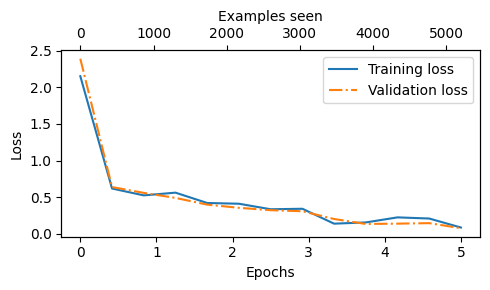

In [32]:
import matplotlib.pyplot as plt

def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

 #1
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

 #2
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)    #3
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()             #4
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)


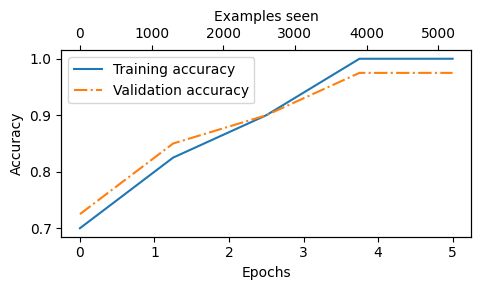

In [33]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(
    epochs_tensor, examples_seen_tensor, train_accs, val_accs,
    label="accuracy"
)


In [34]:
train_accuracy = calc_accuracy_loader_classification(train_loader, model, device)
val_accuracy = calc_accuracy_loader_classification(val_loader, model, device)
test_accuracy = calc_accuracy_loader_classification(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


In [35]:
def classify_review(
        text, model, tokenizer, device, max_length=None,
        pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)          #1
    supported_context_length = model.pos_emb.weight.shape[0]

    input_ids = input_ids[:min(              #2
        max_length, supported_context_length
    )]

    input_ids += [pad_token_id] * (max_length - len(input_ids))    #3

    input_tensor = torch.tensor(
        input_ids, device=device
    ).unsqueeze(0)              #4

    with torch.no_grad():                                #5
        logits = model(input_tensor)[:, -1, :]     #6
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"     #7

In [36]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [37]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [39]:
torch.save(model.state_dict(), "review_classifier.pth")

In [43]:
model_state_dict = torch.load("review_classifier.pth", map_location=device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>